# Poppy Universe – Simulated User Interaction & Trending Model

Welcome to the **Poppy Universe user interaction notebook**!  
The star, planet, and moon datasets are already fully correct. Here, we focus on **building a model to detect trending objects** using simulated interaction data. This is a **sandbox environment** to test ML models — later, the model will be trained on real user data.

---

## Goals

1. **Generate ML-ready features from interactions**  
   - Count views, clicks, favorites, and ratings per object  
   - Compute recency-weighted interaction scores  
   - Track unique users and interaction diversity  

2. **Train a Trending Popularity Model**  
   - Predict which objects are currently gaining attention  
   - Include time decay to reflect recent activity  
   - Use interaction-only features (no object properties)  

3. **Analyze model output**  
   - Rank objects by predicted popularity  
   - Explore trends across stars, planets, and moons  
   - Visualize “top trending objects” for each type  

4. **Prepare output for engine integration**  
   - Save predicted popularity scores to CSV  
   - Make it ready for the C# recommendation engine to consume  

---

## Folder & File References

- **Machine_Learning/Input_Data/simulated_user_interactions.csv** → Simulated interaction dataset  
- **Machine_Learning/Output_Data/Trend_Model_Output.csv/** → Trending popularity model outputs  
- **Machine_Learning/Models/Plots/** → Plots of interaction trends and top objects  

---

> Note: This notebook focuses **on building a trending popularity layer** for the recommendation engine. The real user data will eventually replace the simulated data, but this setup ensures the pipeline works correctly and trends can be detected reliably.


## 0) Imports

In [1]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
import os

from datetime import datetime, timedelta

## 1) Loading the Data

In [ ]:
# Load the simulated user interaction dataset
interactions = pd.read_csv("../../../Input_data/Simulated_User_Interactions.csv")

# Preview first few rows
interactions.head()

,Interaction_ID,User_ID,Object_Type,Object_ID,Interaction_Type,Interaction_Rating,Timestamp
0,1,10,Moon,79,View,NaN,2025-10-27 14:24:22.944331
1,2,6,Planet,47,View,NaN,2025-11-17 18:42:21.193449
2,3,31,Star,52,View,NaN,2025-10-27 22:54:05.245487
3,4,76,Moon,92,View,NaN,2025-11-14 04:45:09.154196
4,5,75,Planet,36,View,NaN,2025-11-08 22:50:31.860243


**Explanation:**  
We’re loading the simulated user interaction data to see what we have. The key columns are:

- `Interaction_ID`: unique identifier for each interaction  
- `User_ID`: the user who performed the interaction  
- `Object_Type`: star, planet, or moon  
- `Object_ID`: unique identifier of the object  
- `Interaction_Type`: view, click, favorite, etc.  
- `Interaction_Rating`: numerical rating for the object (1–5)  
- `Timestamp`: when the interaction occurred  

This gives us the base data we’ll use to compute features like counts, weighted interactions, and recency scores for the trending popularity model.


## 2) Filter and Calculate Scores

In [3]:
# Ensure Timestamp is a datetime object
interactions['Timestamp'] = pd.to_datetime(interactions['Timestamp'])

# Define the recent window (e.g., last 14 days)
recent_window = datetime.now() - timedelta(days=14)
recent_interactions = interactions[interactions['Timestamp'] >= recent_window].copy()

# Calculate decay factor: newer interactions get closer to 1, older closer to 0
# Linear decay: decay = (Timestamp - min_time) / (max_time - min_time)
max_time = recent_interactions['Timestamp'].max()
min_time = recent_interactions['Timestamp'].min()
recent_interactions['decay'] = (recent_interactions['Timestamp'] - min_time) / (max_time - min_time)

# Group by object and aggregate weighted counts
features = recent_interactions.groupby(['Object_Type', 'Object_ID']).agg(
    total_interactions=('Interaction_Type', 'count'),
    num_views=('Interaction_Type', lambda x: ((x == 'View') * recent_interactions.loc[x.index, 'decay']).sum()),
    num_clicks=('Interaction_Type', lambda x: ((x == 'Click') * recent_interactions.loc[x.index, 'decay']).sum()),
    num_favorites=('Interaction_Type', lambda x: ((x == 'Favorite') * recent_interactions.loc[x.index, 'decay']).sum())
).reset_index()

# Calculate weighted trending score with decay
features['trending_score'] = features['num_views']*1 + features['num_clicks']*2 + features['num_favorites']*3

# Round to 3 decimals
features['trending_score'] = features['trending_score'].round(3)

# Preview
features.head()


,Object_Type,Object_ID,total_interactions,num_views,num_clicks,num_favorites,trending_score
0,Moon,1,10,4.564596,0.561023,0.498789,7.183
1,Moon,2,9,1.004520,2.402861,1.528235,10.395
2,Moon,3,3,0.467788,0.000000,0.806064,2.886
3,Moon,4,14,4.222938,2.722611,0.774596,11.992
4,Moon,5,6,1.564307,1.882376,0.000000,5.329


**Explanation:**  
- Add a **decay factor** so that interactions closer to today count more than older ones.  
- Decay is calculated linearly within the recent window: `0` = oldest, `1` = newest.  
- Multiply each interaction by its decay before summing up `num_views`, `num_clicks`, and `num_favorites`.  
- Compute the **weighted trending score** as before, but now recent interactions have more influence.  
- Round scores to **3 decimals** for readability.  
- This makes the trending score **more sensitive to current activity**, rather than treating all interactions in the window equally.

## 2) Sort Objects by Trending Score

In [4]:
# Sort objects by trending score descending
top_trending = features.sort_values('trending_score', ascending=False)

# Show top 10 trending objects
top_trending[['Object_Type', 'Object_ID', 'trending_score']].head(10)

,Object_Type,Object_ID,trending_score
148,Planet,49,19.660
179,Planet,80,19.383
111,Planet,12,18.743
241,Star,42,18.080
172,Planet,73,16.707
72,Moon,73,16.572
238,Star,39,16.552
379,Star,180,15.681
363,Star,164,15.671
197,Planet,98,15.269


**Explanation:**  
- Sort the objects in descending order of `trending_score` to see which ones are trending the most.  
- Display the **top 10 objects** for a quick look.  
- At this stage, we now know which stars, planets, or moons are currently popular based on recent user interactions.

## 3) Visualize Top trending Objects

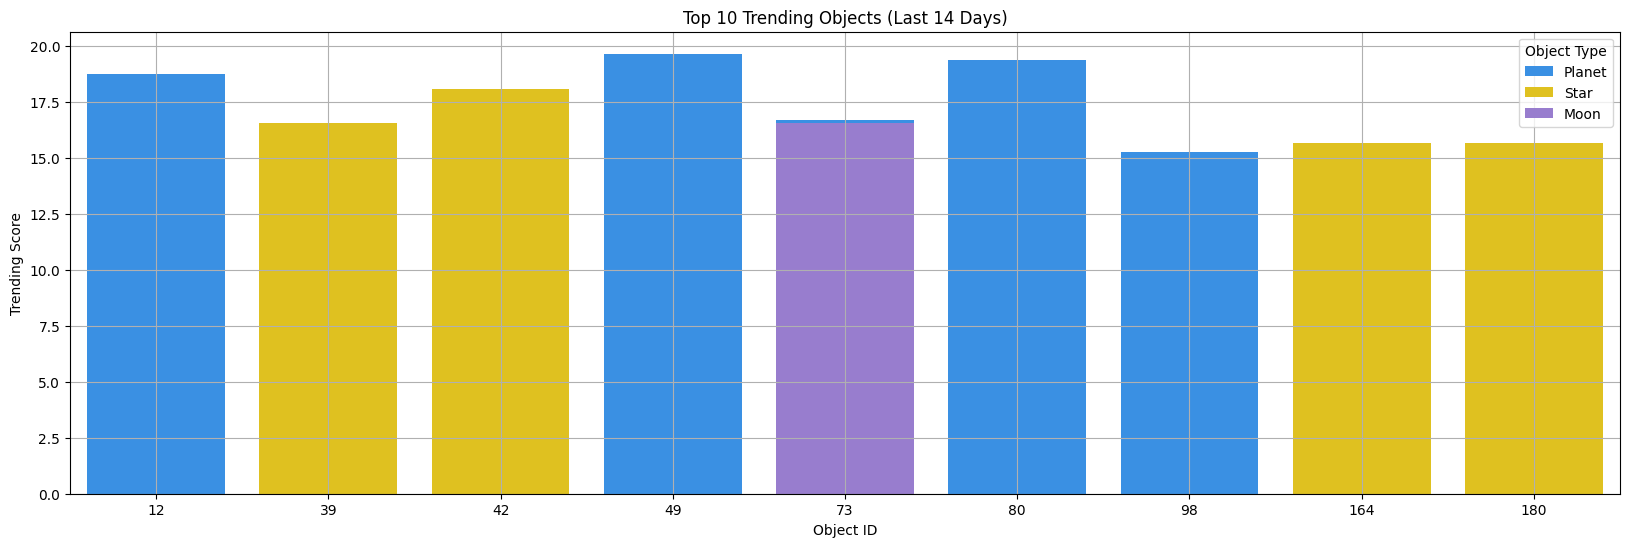

In [ ]:
# Take top 10 trending objects and sort by trending_score descending
top10 = top_trending.head(10).sort_values('trending_score', ascending=False)

# Custom space-themed palette
space_palette = {
    'Star': '#FFD700',      # gold/yellow for stars
    'Planet': '#1E90FF',    # dodger blue for planets
    'Moon': '#9370DB'       # medium purple for moons
}

# Plot top 10 trending objects
plt.figure(figsize=(20,6))
sns.barplot(
    y='trending_score', 
    x='Object_ID', 
    hue='Object_Type', 
    data=top10,
    dodge=False,
    palette=space_palette
)

plt.xlabel("Object ID")
plt.ylabel("Trending Score")
plt.title("Top 10 Trending Objects (Last 14 Days)")
plt.legend(title='Object Type')
plt.grid(True)

# Save plot
os.makedirs("Plots", exist_ok=True)
plt.savefig("../../Plots/L2_top_trending_objects.png", bbox_inches='tight')

# Show plot in notebook
plt.show()


**Explanation:**  
- Applied a **space-themed color palette**: gold for stars, blue for planets, purple for moons.  
- Keeps bars **sorted by trending score** descending.  
- Horizontal barplot shows the **top 10 trending objects** clearly.  
- Labels, grid, and legend make it easy to interpret while keeping a **space-inspired look**.

## 4) Export Top 10 Objects per Category to a csv File 

In [ ]:
top_per_type = features.sort_values('trending_score', ascending=False) \
                       .groupby('Object_Type') \
                       .head(100)  # pick top 10 per type

# Export to CSV for your next layer
top_per_type.to_csv('../../../Output_Data/Layer_2_Top_Trending_Per_Type.csv', index=False)
top_per_type.head()

,Object_Type,Object_ID,total_interactions,num_views,num_clicks,num_favorites,trending_score
148,Planet,49,20,4.281715,4.606434,2.055229,19.660
179,Planet,80,16,3.209625,2.504674,3.721200,19.383
111,Planet,12,15,4.604754,2.973837,2.730085,18.743
241,Star,42,17,4.309808,3.047806,2.558272,18.080
172,Planet,73,19,5.484187,3.504298,1.404788,16.707
